# Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from common import *

# 1. Load dataset

In [2]:
train_data = pd.read_csv(join(PATH.input, "train_data.csv"))
sample_submission = pd.read_csv(join(PATH.input, "sample_submission.csv"))
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


# 2. Preprocessing

## 1) Generate `Time`

In [3]:
%%time
train_data = generate_full_timestamp(train_data)

CPU times: user 9.06 s, sys: 178 ms, total: 9.24 s
Wall time: 7.21 s


## 2) Imputing

In [4]:
train_data = impute_data(train_data)

Number of Nan values: 0


## 3) Feature engineering

In [5]:
train_data = preprocess(train_data)
train_data.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Time,X,Y,Etmp_abs,Wdir_adj,Wspd_cos,Wspd_sin,RPM,P_max
0,1,1,2,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66,1,3349.8515,5939.23193,273.88,21.93,6.155045,-0.429323,16.034441,0.857621
1,1,1,2,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66,2,3349.8515,5939.23193,273.88,21.93,6.155045,-0.429323,16.034441,0.857621
2,1,1,3,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76,3,3349.8515,5939.23193,273.75,18.73,6.265462,-0.238505,16.322087,0.900427
3,1,1,4,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53,4,3349.8515,5939.23193,273.67,20.18,6.419479,-0.081794,16.723314,0.966892
4,1,1,5,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36,5,3349.8515,5939.23193,273.64,21.80,6.249246,0.097080,16.279842,0.892196


In [6]:
train_data.drop(columns=['Day', 'Wdir', 'Etmp_abs'], inplace=True)
train_data.head()

,TurbID,Tmstamp,Wspd,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Time,X,Y,Wdir_adj,Wspd_cos,Wspd_sin,RPM,P_max
0,1,2,6.17,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66,1,3349.8515,5939.23193,21.93,6.155045,-0.429323,16.034441,0.857621
1,1,2,6.17,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66,2,3349.8515,5939.23193,21.93,6.155045,-0.429323,16.034441,0.857621
2,1,3,6.27,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76,3,3349.8515,5939.23193,18.73,6.265462,-0.238505,16.322087,0.900427
3,1,4,6.42,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53,4,3349.8515,5939.23193,20.18,6.419479,-0.081794,16.723314,0.966892
4,1,5,6.25,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36,5,3349.8515,5939.23193,21.80,6.249246,0.097080,16.279842,0.892196


## 3) Split data

In [7]:
IN_SEQ_LEN  = 2*144
OUT_SEQ_LEN = 2*144
STRIDE      = 1*144
SHUFFLE     = False
TEST_SIZE   = 0.2

In [8]:
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(train_data, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, TEST_SIZE)
# train_y = train_y[:, :, 10]
# val_y   = val_y[:, :, 10]
# print("y:", train_y.shape, val_y.shape)

100%|██████████| 134/134 [00:13<00:00, 10.10it/s]


Train data(X, y)     : (20368, 288, 18) (20368, 288, 18)
Validation data(X, y): (5226, 288, 18) (5226, 288, 18)
Test data(X)         : (134, 288, 18)


## 4) Scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x.reshape(-1, train_x.shape[-1])).reshape(train_x.shape)
val_x   = scaler.transform(val_x.reshape(-1, val_x.shape[-1])).reshape(val_x.shape)
test_x  = scaler.transform(test_x.reshape(-1, test_x.shape[-1])).reshape(test_x.shape)

# 3. Modeling

In [23]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, GRU, Bidirectional, RepeatVector, TimeDistributed, Dropout, BatchNormalization

tf.keras.utils.set_random_seed(RANDOM_STATE)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
# model = Sequential([
#     Input(shape=train_x[0].shape),
#     Bidirectional(GRU(256)),
#     RepeatVector(train_x.shape[1]),
#     Bidirectional(GRU(256, return_sequences=True)),
#     Dropout(0.4),
#     TimeDistributed(Dense(18))
# ])
# optimizer = tf.optimizers.Nadam(1e-2)
# model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
# model.summary()

# print("Input shape:", (None, *train_x[0].shape))

2022-07-12 16:35:36.408095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-12 16:35:36.408890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 16:35:36.409163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 16:35:36.409356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 512)              423936    
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 288, 512)         0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 288, 512)         1182720   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 288, 512)          0         
                                                                 
 time_distributed (TimeDistr  (None, 288, 18)          9234      
 ibuted)                                                

In [25]:
model = Sequential([
    GRU(256, input_shape=train_x[0].shape, return_sequences=True),
    Dropout(0.4),
    GRU(256, input_shape=train_x[0].shape, return_sequences=True),
    
    Dropout(0.4),
    BatchNormalization(),
    Dense(256, activation='relu'),
    
    Dropout(0.4),
    BatchNormalization(),
    Dense(128, activation='relu'),
    
    Dropout(0.4),
    BatchNormalization(),
    Dense(18, activation='relu'),
])
optimizer = tf.optimizers.Nadam(1e-2)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

print("Input shape:", (None, *train_x[0].shape))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 288, 256)          211968    
                                                                 
 dropout_12 (Dropout)        (None, 288, 256)          0         
                                                                 
 gru_13 (GRU)                (None, 288, 256)          394752    
                                                                 
 dropout_13 (Dropout)        (None, 288, 256)          0         
                                                                 
 batch_normalization_3 (Batc  (None, 288, 256)         1024      
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 288, 256)          65792     
                                                      

# 4. Training

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=1000, batch_size=128,
          callbacks=[
              EarlyStopping(patience=10, restore_best_weights=True),
              ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1),
          ]);

Epoch 1/1000
160/160 [==============================] - 12s 55ms/step - loss: 12962654.0000 - mae: 1175.4286 - val_loss: 35142920.0000 - val_mae: 1868.2279 - lr: 0.0100
Epoch 2/1000
160/160 [==============================] - 8s 50ms/step - loss: 10292774.0000 - mae: 1076.3048 - val_loss: 23668770.0000 - val_mae: 1591.1504 - lr: 0.0100
Epoch 3/1000
160/160 [==============================] - 8s 50ms/step - loss: 6602891.5000 - mae: 901.9838 - val_loss: 11940323.0000 - val_mae: 1218.0901 - lr: 0.0100
Epoch 4/1000
160/160 [==============================] - 8s 50ms/step - loss: 3710585.7500 - mae: 686.2336 - val_loss: 4218573.0000 - val_mae: 815.5676 - lr: 0.0100
Epoch 5/1000
160/160 [==============================] - 8s 49ms/step - loss: 1217995.1250 - mae: 406.6578 - val_loss: 3890314.2500 - val_mae: 700.4755 - lr: 0.0100
Epoch 6/1000
160/160 [==============================] - 8s 50ms/step - loss: 636116.8750 - mae: 307.3697 - val_loss: 2760279.0000 - val_mae: 611.2420 - lr: 0.0100
Epoch 

160/160 [==============================] - 8s 50ms/step - loss: 150987.0781 - mae: 160.4544 - val_loss: 796685.5000 - val_mae: 304.1743 - lr: 0.0053
Epoch 46/1000
160/160 [==============================] - ETA: 0s - loss: 147433.7188 - mae: 158.7791
Epoch 46: ReduceLROnPlateau reducing learning rate to 0.004782968759536744.
160/160 [==============================] - 8s 50ms/step - loss: 147433.7188 - mae: 158.7791 - val_loss: 861412.7500 - val_mae: 291.7859 - lr: 0.0053
Epoch 47/1000
160/160 [==============================] - 8s 50ms/step - loss: 145640.7656 - mae: 157.7030 - val_loss: 835415.5625 - val_mae: 303.4398 - lr: 0.0048
Epoch 48/1000
160/160 [==============================] - 8s 51ms/step - loss: 146773.6406 - mae: 158.5398 - val_loss: 752811.6250 - val_mae: 273.6037 - lr: 0.0048
Epoch 49/1000
160/160 [==============================] - 8s 50ms/step - loss: 146867.1406 - mae: 158.2288 - val_loss: 597607.1250 - val_mae: 271.5857 - lr: 0.0048
Epoch 50/1000
160/160 [=============

# 5. Check validation set

In [27]:
y_true = val_y[:, :, 9]
y_pred = model.predict(val_x)[:, :, 9]

164/164 [==============================] - 3s 13ms/step


In [28]:
y_pred[0]

array([471.142, 462.191, 464.833, 464.795, 464.748, 464.609, 464.421, 464.301, 464.255, 464.137,
       464.071, 464.010, 463.936, 463.888, 463.782, 463.791, 463.738, 463.742, 463.724, 463.747,
       463.735, 463.788, 463.734, 463.752, 463.826, 463.835, 463.866, 463.880, 463.881, 463.940,
       463.901, 463.986, 464.037, 464.027, 464.082, 464.131, 464.119, 464.209, 464.219, 464.237,
       464.322, 464.315, 464.370, 464.405, 464.345, 464.364, 464.396, 464.401, 464.427, 464.433,
       464.456, 464.468, 464.470, 464.498, 464.537, 464.543, 464.522, 464.524, 464.550, 464.560,
       464.596, 464.612, 464.612, 464.625, 464.635, 464.652, 464.667, 464.711, 464.718, 464.733,
       464.787, 464.786, 464.802, 464.813, 464.842, 464.851, 464.873, 464.909, 464.896, 464.917,
       464.921, 464.951, 465.005, 465.029, 465.000, 465.017, 465.037, 465.051, 465.073, 465.090,
       465.083, 465.109, 465.099, 465.089, 465.130, 465.148, 465.148, 465.160, 465.189, 465.218,
       465.233, 465.234, 465.2

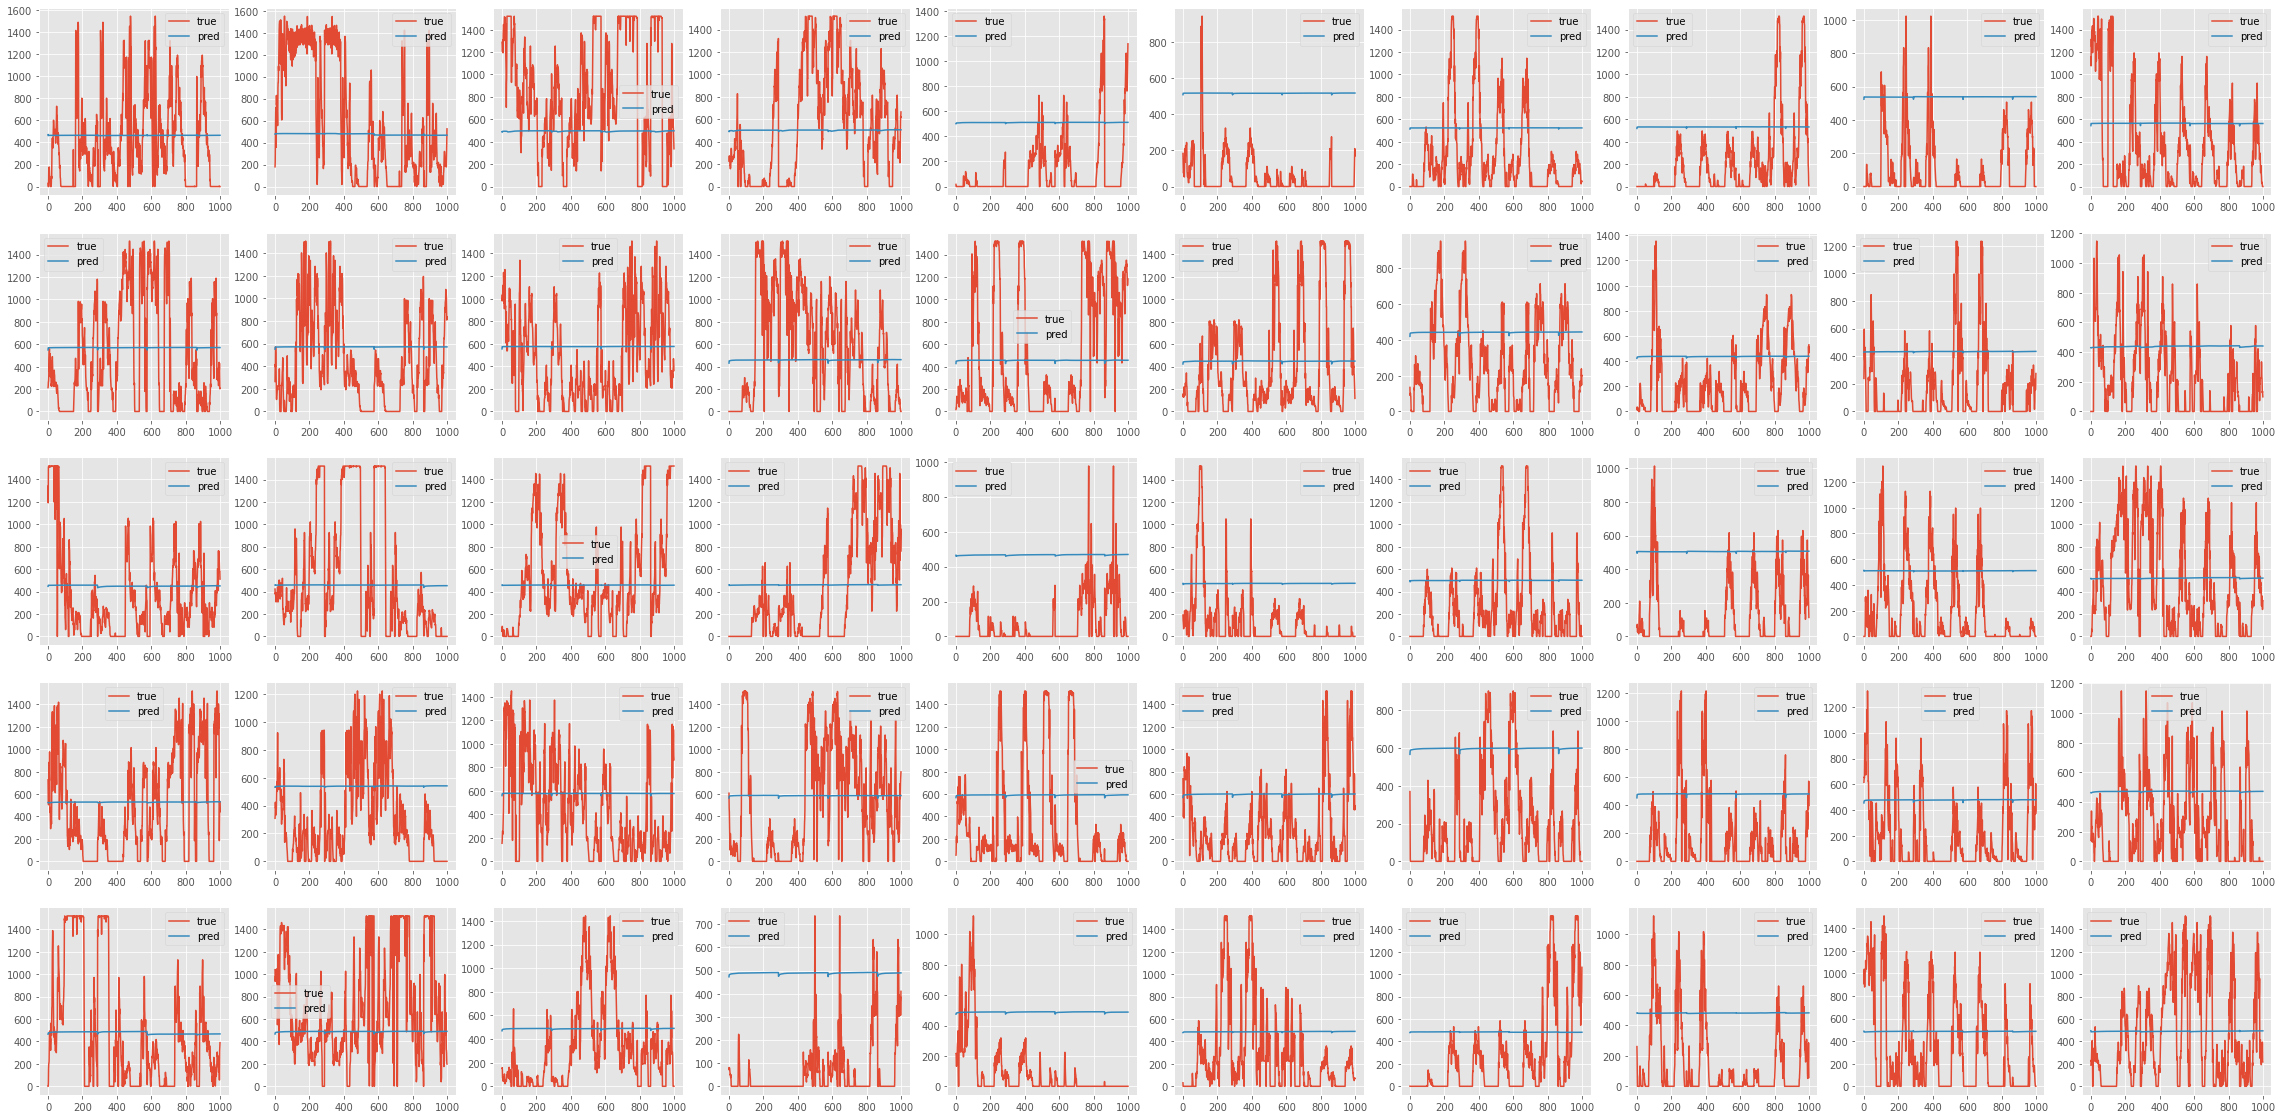

In [29]:
plt.style.use('ggplot')

fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[37*i:37*(i+1)].reshape(-1)[:1000]
    y_p = y_pred[37*i:37*(i+1)].reshape(-1)[:1000]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

# 6. Generate submission

In [33]:
test_x.shape

(134, 288, 18)

In [34]:
sample_submission['Patv'] = model.predict(test_x)[:, :, 9].reshape(-1)
sample_submission.to_csv(join(PATH.output, "proposed10.csv"), index=False)

5/5 [==============================] - 0s 12ms/step
